In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [77]:
train = pd.read_csv("train.csv")
train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [78]:
test = pd.read_csv("test.csv")
test.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7905,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,7906,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,7907,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,7908,2330,D-penicillamine,20510,F,N,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,7909,1615,D-penicillamine,21904,F,N,Y,N,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0


In [79]:
train.drop('id', axis= 1, inplace=True)

In [80]:
test.drop('id', axis= 1, inplace=True)

In [81]:
from sklearn.calibration import LabelEncoder


le = LabelEncoder()

y = le.fit_transform(train['Status'])
X = train.drop('Status', axis=1)

In [82]:
X = pd.get_dummies(X, drop_first=True)

In [83]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline


kfold = StratifiedKFold(shuffle=True, random_state=24, n_splits=5)

dtc = DecisionTreeClassifier(random_state=24)
dtc.fit(X, y)

params = {'max_depth': range(2,1100,50), 
          'min_samples_split': range(2,1100,50),
          'min_samples_leaf': range(2,1100,50)}

gcv = GridSearchCV(dtc, param_grid=params, cv=kfold, scoring='neg_log_loss')

gcv.fit(X, y)

print(gcv.best_params_)
print(gcv.best_score_)

{'max_depth': 52, 'min_samples_leaf': 202, 'min_samples_split': 502}
-0.5318066450146576


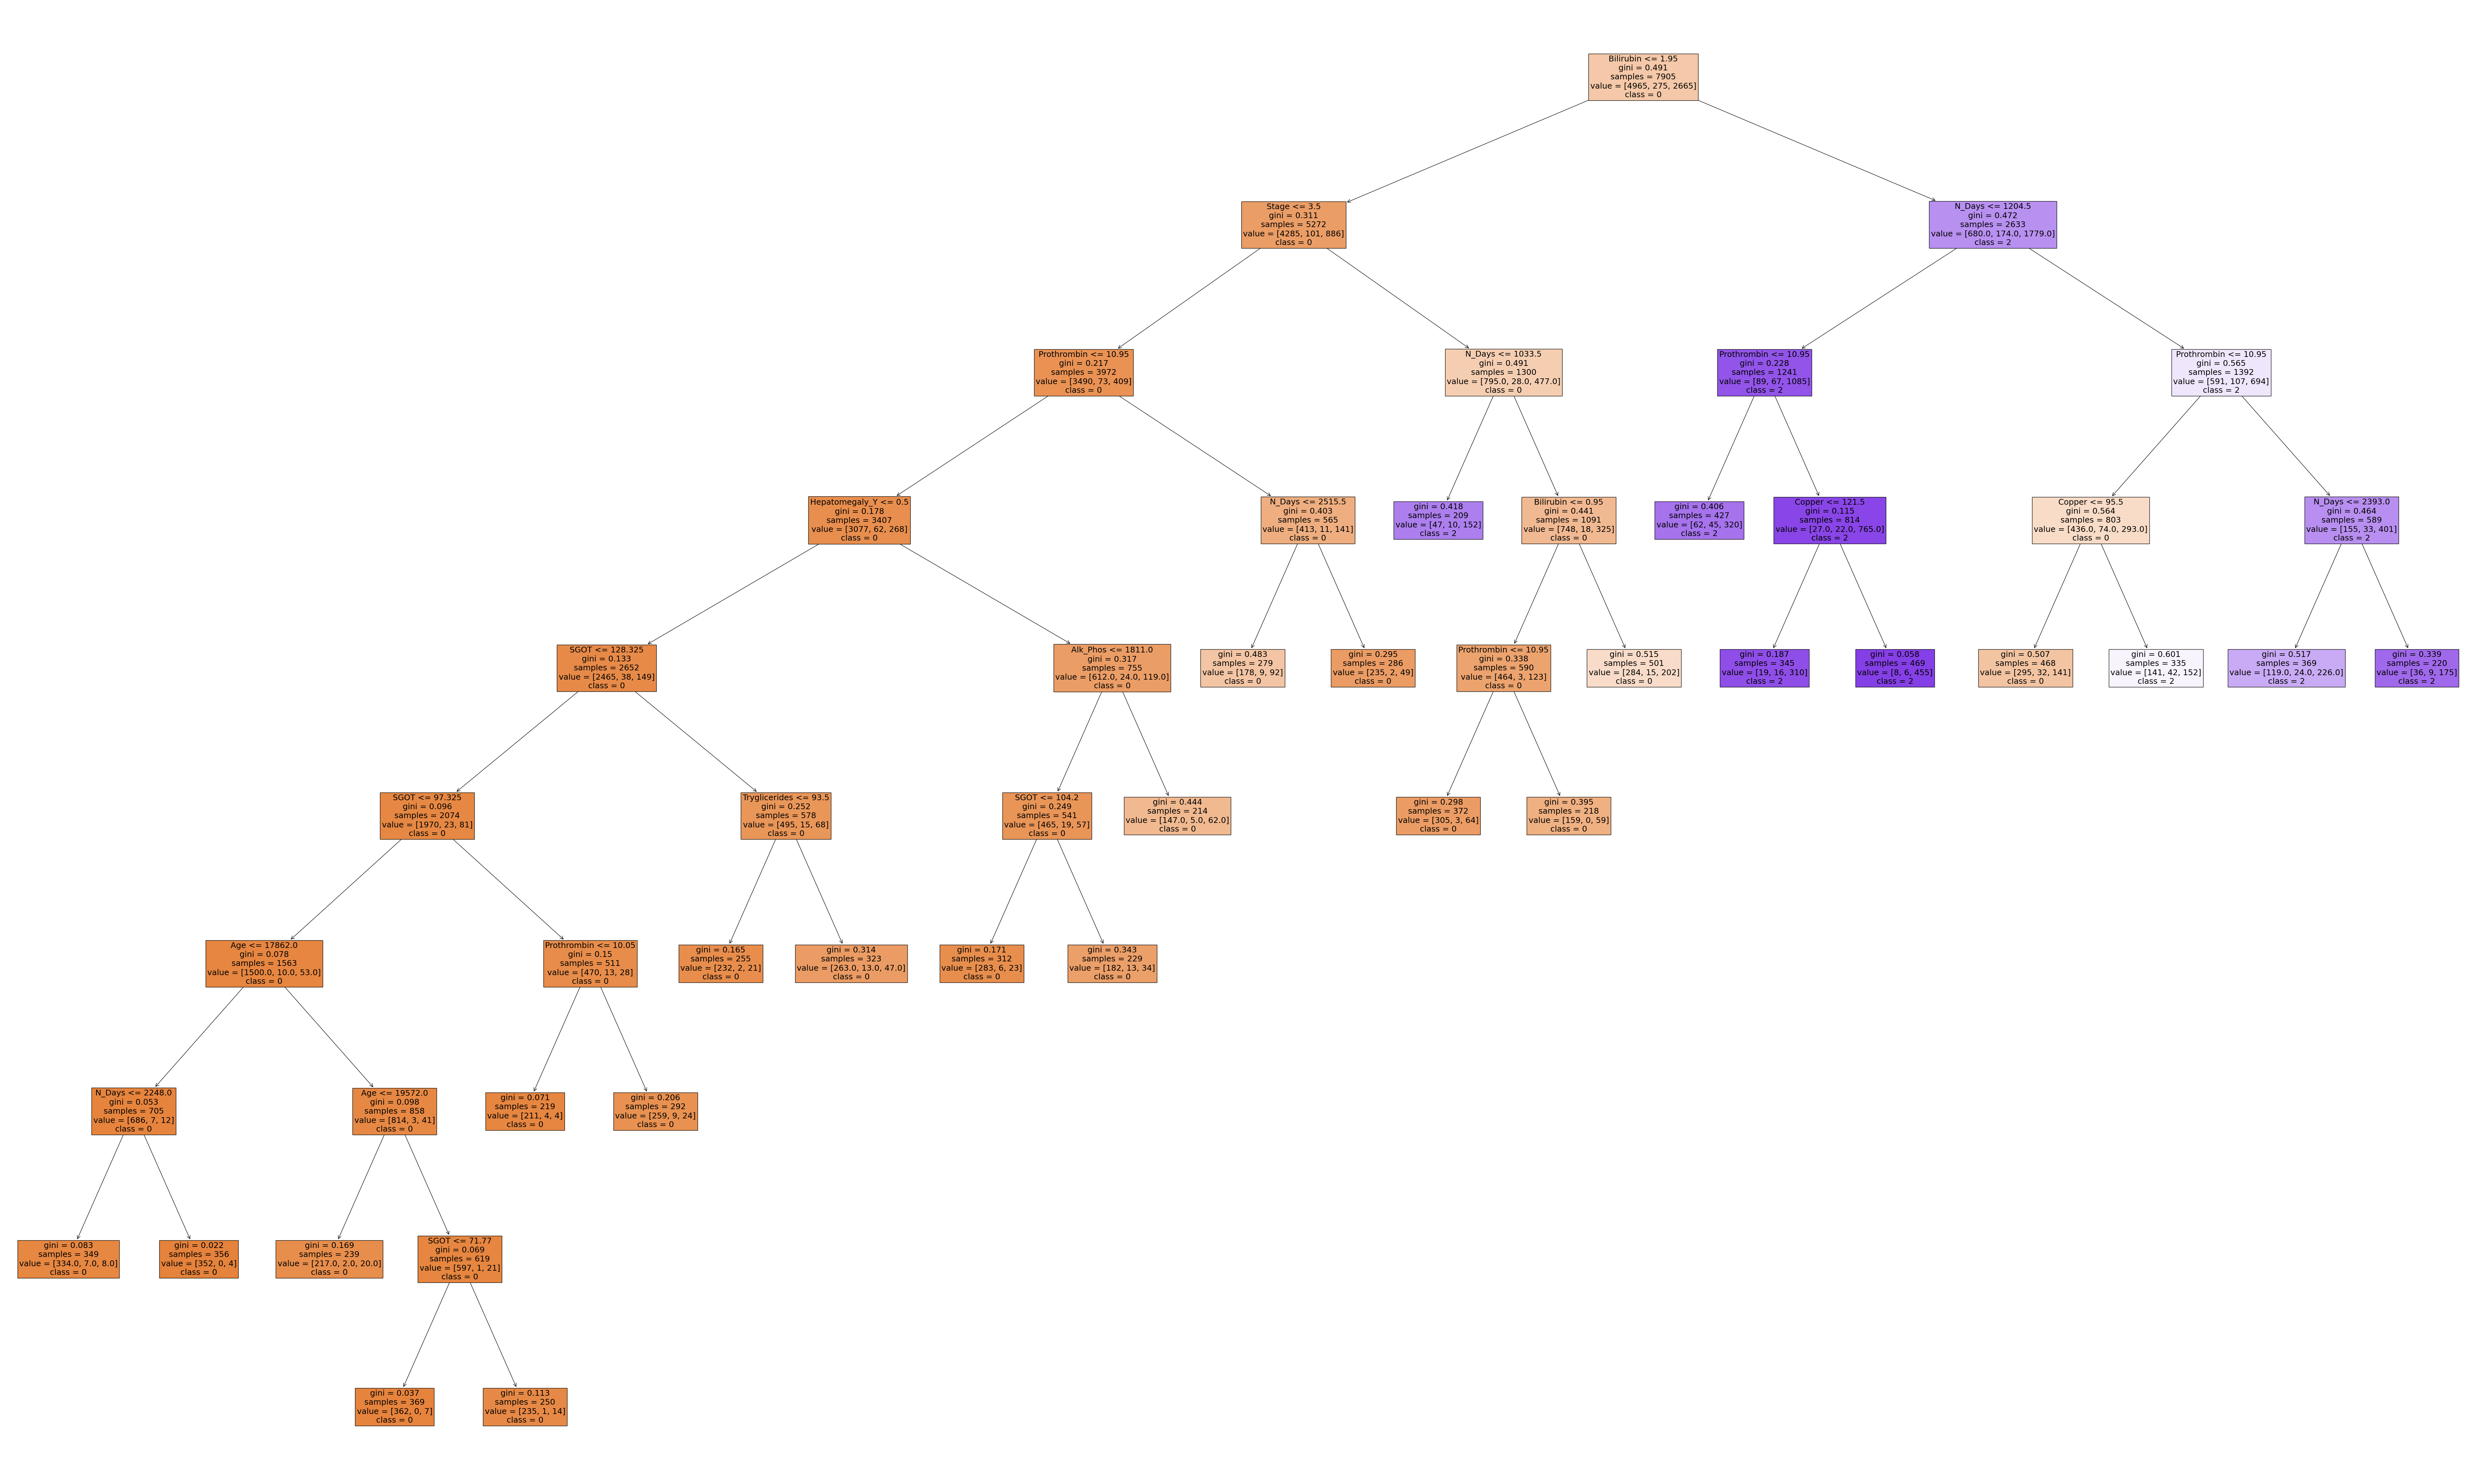

In [84]:
best_tree = gcv.best_estimator_

plt.figure(figsize=(100,60))
plot_tree(best_tree,feature_names=list(X.columns),
               class_names=['0', '1', '2'],
               filled=True,fontsize=18
               )
plt.show() 

In [85]:
df_imp = pd.DataFrame({'Features': list(X.columns), 'Fea_Imp':list(best_tree.feature_importances_)})


<Axes: xlabel='Fea_Imp', ylabel='Features'>

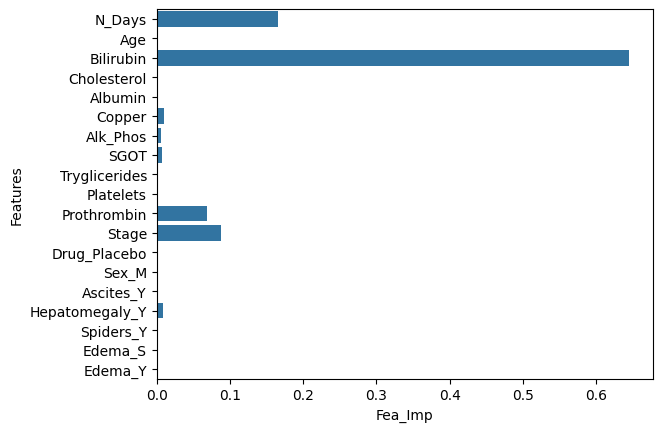

In [86]:
sns.barplot(data=df_imp, y="Features", x="Fea_Imp",orient='h')


In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                   stratify=y,
                                   random_state=24)

# dtc = DecisionTreeClassifier(random_state=24, max_depth=4, min_samples_leaf=2, min_samples_split=)
# dtc.fit(X_train, y_train)

# plt.figure(figsize=(25,20))
# plot_tree(dtc,feature_names=list(X.columns),
#                class_names=['0','1','2'],
#                filled=True,fontsize=32)
# plt.show() 

y_pred = best_tree.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7991906929691451


In [88]:
test1 = pd.get_dummies(test, drop_first=True)

In [89]:
y_pred_prob = best_tree.predict_proba(test1)

In [90]:
y_pred_prob

array([[0.79475983, 0.05676856, 0.14847162],
       [0.81424149, 0.04024768, 0.14551084],
       [0.05507246, 0.04637681, 0.89855072],
       ...,
       [0.79475983, 0.05676856, 0.14847162],
       [0.95702006, 0.02005731, 0.02292264],
       [0.32249322, 0.06504065, 0.61246612]])

In [91]:
temp = pd.read_csv('test.csv')

In [92]:
submit = pd.DataFrame({"id":temp['id'],"Status_C":y_pred_prob[:,0], 'Status_CL':y_pred_prob[:,1], 'Status_D':y_pred_prob[:,2]})

In [94]:
submit.to_csv("Cirrhosis_DTC_v3.csv" , index = False)